## 1. Import and Data Initialisation

In [2]:
import xarray as xr
import pandas as pd
import rasterio
import os
from rasterio.mask import mask
from rasterio.transform import from_bounds
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import dask


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', True)
pd.set_option('large_repr','truncate')
pd.set_option('display.width', 1000)

In [3]:
from data_creation import download_data
download_data()
# If it doesn't work just download it and put the data folder in the root folder of the repository

Data folder already exists at :  c:\Users\Alec\Desktop\Github Repositories\GenHack-Team28\data


In [4]:
current_working_dir = os.getcwd()
project_root = os.path.dirname(current_working_dir)
main_data_folder = os.path.join(project_root, "data")

era5_data_folder = os.path.join(main_data_folder, "derived-era5-land-daily-statistics")
ndvi_data_folder = os.path.join(main_data_folder, "sentinel2_ndvi")
eca_tx_datafolder = os.path.join(main_data_folder, "ECA_blend_tx")

gadm_filepath = os.path.join(main_data_folder, "gadm_410_europe.gpkg")
stations_filepath = os.path.join(eca_tx_datafolder, "stations.txt")

## 2. Geometry

### 2.1 Parametrize

In [5]:
country_code = "FRA"
cityname = "Lyon"

### 2.2 Get the geometry

In [6]:
# Initialize gdf
gadm_gdf = gpd.read_file(gadm_filepath)

# Filtering on France and Lyon arrondissements
lyon_arrondissements = [ "Lyon, 1er arrondissement",
                          "Lyon, 2e arrondissement",
                         "Lyon, 3e arrondissement",
                         "Lyon, 4e arrondissement",
                         "Lyon, 5e arrondissement",
                         "Lyon, 6e arrondissement",
                         "Lyon, 7e arrondissement",
                         "Lyon, 8e arrondissement",
                         "Lyon, 9e arrondissement" ]
filtered_gadm_gdf = gadm_gdf[(gadm_gdf.GID_0 == "FRA") & (gadm_gdf.NAME_5.isin(lyon_arrondissements))]

# Get the geometry
one_area_gdf = gadm_gdf[gadm_gdf.NAME_3 == cityname].dissolve()
one_city_gdf = filtered_gadm_gdf.dissolve()

<Axes: >

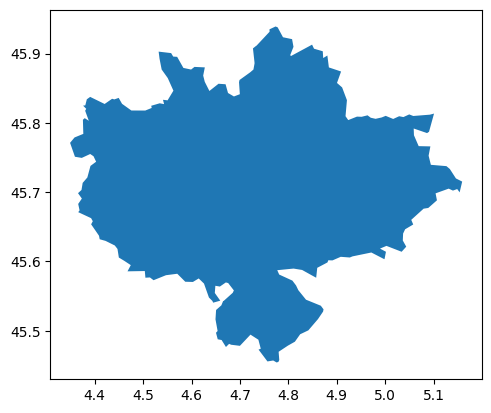

In [7]:
one_area_gdf.plot()

## 3. ERA5

### 3.1 Parametrize

In [8]:
variable2statistic = {
    "2m_temperature": "daily_maximum",
    "total_precipitation": "daily_mean",
    "10m_u_component_of_wind": "daily_mean",
    "10m_v_component_of_wind": "daily_mean",
}

variable2datavar = {
    "2m_temperature": "t2m",
    "total_precipitation": "tp",
    "10m_u_component_of_wind": "u10",
    "10m_v_component_of_wind": "v10",
}

In [9]:
variable = "2m_temperature"
year = 2024

statistic = variable2statistic[variable]
datavar = variable2datavar[variable]

filepath = f"{era5_data_folder}/{year}_{variable}_{statistic}.nc"

## 4. Weather Stations

### 4.1 Initialize

In [10]:
# Filepaths
eca_tx_datafolder = main_data_folder + "/ECA_blend_tx/"
stations_filepath = eca_tx_datafolder + "stations.txt"

def dms_to_decimal(dms_str):
    # This function converts a DMS (Degrees:Minutes:Seconds) string to decimal degrees.
    dms_str = dms_str.strip()

    sign = 1 if dms_str[0] == '+' else -1

    dms_str = dms_str[1:]

    parts = dms_str.split(':')
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])

    decimal = sign * (degrees + minutes/60 + seconds/3600)

    return decimal

# Initialize stations dataframe
stations_df = pd.read_csv(
    stations_filepath,
    skiprows=17,
    skipinitialspace=True
)

stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']),
    crs="EPSG:4326" # (WGS84, adequate for lat/lon coordinates)
).drop(columns=['LAT', 'LON', 'LAT_decimal', 'LON_decimal'])

# Select the stations within the Lyon administrative area
one_area_gdf.to_crs(stations_gdf.crs, inplace=True) # Use same CRS for spatial operations
stations_in_city_gdf = stations_gdf[stations_gdf.within(one_area_gdf.geometry.iloc[0])] # Only 1 station in Lyon administrative area

Visualization of staitions in the administrative area

In [11]:
def plot_stations_in_city(one_city_gdf, one_area_gdf, stations_in_city_gdf, cityname):
    fig, ax = plt.subplots(figsize=(6, 6))

    one_city_gdf.plot(ax=ax, alpha=0.3, color='blue', linewidth=2, label='Lyon city')
    one_area_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='Lyon area boundary')

    stations_in_city_gdf.plot(ax=ax, color='red', markersize=100, marker='*', label=f'Stations in {cityname}')

    plt.legend()
    plt.title(f"Location of weather stations in {cityname}")
    plt.tight_layout()
    plt.show()

### 4.2 Weather stations in Lyon data extraction

In [12]:
# We take the staids of the stations in the area as a list
stations_in_city_staids = stations_in_city_gdf['STAID'].tolist()

# We take the first station in the list
station_data_filepath = eca_tx_datafolder + f"TX_STAID{stations_in_city_staids[0]:06d}.txt"

station_data_df = pd.read_csv(
    station_data_filepath,
    skiprows=20,
    skipinitialspace=True
)

valid_data_df = station_data_df[station_data_df['Q_TX'] == 0].copy() # Q_TX is the quality code for TX (0='valid')
valid_data_df['DATE'] = pd.to_datetime(valid_data_df['DATE'], format='%Y%m%d')
valid_data_df['TX_celsius'] = valid_data_df['TX'] / 10 # Convert temperature to °C (originally stored in 0.1°C unit)

tx_timeseries = pd.Series(
    valid_data_df['TX_celsius'].values,
    index=valid_data_df['DATE']
)

## 5. Discrepancies Measurement

*   ERA5 vs Weather station : Metrics should answer the question how much ERA5 misses local urban temperature (by season,day/night)
*   NDVI vs Weather station: Actually, It's not about comparison (cause the both datasets doesn't measure the same things).but Rather a study of correlation. Here, our metrics should answer the question how vegetation affects temperature


At this level, the metric used is Mean Absolute Error ( MAE). The goal is to measure how much ERA5 temperature data misses temperature provided by weather station. We focus on the year 2024 because, based on our previous analyses, the temperature behaviour remains the same from year to year: showing the same trends and seasonality patterns.
On one hand, we compute an overall MAE to capture the global bias, and on the other hand, we calculate seasonal MAEs to further refine our understanding of the bias

In [13]:
# ERA5 data
filepaths = glob(f"{era5_data_folder}/202[0-9]_{variable}_{statistic}.nc")
era5_temp_2024= xr.open_mfdataset(filepaths, combine="by_coords")

station_geom = stations_in_city_gdf.iloc[0].geometry
era5_point = era5_temp_2024.sel(latitude=station_geom.y, longitude=station_geom.x, method="nearest")

era5_values = era5_point.to_array().squeeze().values
era5_times =era5_temp_2024.valid_time.values

# Create ERA5 temperature time-aligned series
era5_series = pd.Series(
    era5_values,
    index=pd.to_datetime(era5_times)
)
# Convert ERA5 temperature from Kelvin to Celsius
if era5_series.min() < 200:
    era5_series = era5_series - 273.15


# Weather station temperature in the year 2024
weath_temp_2024 = tx_timeseries[tx_timeseries.index.year == 2024]


# Merge the both time series
comparison_df = pd.DataFrame({
    'ERA5': era5_series,
    'Weather Station': weath_temp_2024
})

# Adding mae
comparison_df['absolute_error'] = (comparison_df['ERA5'] - comparison_df['Weather Station']).abs()

# Delete Missing values
comparison_df = comparison_df.dropna()

comparison_df.head()

,ERA5,Weather Station,absolute_error
2024-01-01,282.251556,11.1,271.151556
2024-01-02,282.234344,10.9,271.334344
2024-01-03,285.985107,15.2,270.785107
2024-01-04,284.560638,13.8,270.760638
2024-01-05,281.277100,8.3,272.977100


In [14]:
# Adding time indexes to the dataframe
comparison_df['time'] = comparison_df.index
comparison_df['month'] = comparison_df['time'].dt.month
comparison_df['hour'] = comparison_df['time'].dt.hour
comparison_df['date'] = comparison_df['time'].dt.date

# Defining seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

comparison_df['season'] = comparison_df['month'].apply(get_season)

# Defining Day/Night: day(6am-6pm),else Night
def get_day_night(hour):
    if 6 <= hour < 18:
        return 'Day'
    else:
        return 'Night'

comparison_df['day_night'] = comparison_df['hour'].apply(get_day_night)

In [15]:
# Metrics calculation
summary_data = []

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    season_data = comparison_df[comparison_df['season'] == season]

    # Day
    day_data = season_data[season_data['day_night'] == 'Day']
    mae_day = day_data['absolute_error'].mean() if len(day_data) > 0 else np.nan
    n_day = len(day_data)

    # Night
    night_data = season_data[season_data['day_night'] == 'Night']
    mae_night = night_data['absolute_error'].mean() if len(night_data) > 0 else np.nan 
    n_night = len(night_data)

    # Global season
    mae_global_season = season_data['absolute_error'].mean()

    summary_data.append({
        'Season': season,
        'Day MAE (°C)': mae_day,
        'Number of Days ': n_day,
        'Night MAE (°C)': mae_night,
        'Number of Nights': n_night,
        'Season MAE (°C)': mae_global_season,
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(3)

print(summary_df.to_string(index=False))

Season  Day MAE (°C)  Number of Days   Night MAE (°C)  Number of Nights  Season MAE (°C)
Winter           NaN                0         272.988                91          272.988
Spring           NaN                0         272.031                92          272.031
Summer           NaN                0         271.450                92          271.450
Autumn           NaN                0         272.727                91          272.727


## 6. Relation between temperature and NDVI

In [16]:
def quarter2timeperiod(year, quarter):
    if quarter == 1:
        return f"{year-1}-12-01_{year}-03-01"
    elif quarter == 2:
        return f"{year}-03-01_{year}-06-01"
    elif quarter == 3:
        return f"{year}-06-01_{year}-09-01"
    elif quarter == 4:
        return f"{year}-09-01_{year}-12-01"
    else:
        raise ValueError("quarter must be in 1, 2, 3, 4")

available_years = [2020, 2021, 2022, 2023]
available_quarters = [1, 2, 3, 4]

year = 2021
quarter = 1

timeperiod = quarter2timeperiod(year, quarter)
filepath  = f"{ndvi_data_folder}/ndvi_{timeperiod}.tif"

In [21]:
def convert_ndvi_to_real_scale(ndvi_img, out_meta):
    # The NDVI is stored in int8 format on a 0/254 scale, and nodata is 255.
    # This function converts it to a float format on a -1/1 scale, and replace nodata with np.nan.
    ndvi_img = ndvi_img.astype(float)
    ndvi_img[ndvi_img == out_meta["nodata"]] = np.nan
    ndvi_img = ndvi_img / 254 * 2 - 1
    return ndvi_img

def get_out_image_and_metadata(filepath, one_city_gdf):
    with rasterio.open(filepath) as src:
        one_city_gdf_in_good_crs = one_city_gdf.to_crs(src.crs)
        city_geometry = [one_city_gdf_in_good_crs.geometry.iloc[0]]
        out_image, out_transform = mask(src, city_geometry, crop=True)
        out_meta = src.meta

        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        real_out_image = convert_ndvi_to_real_scale(out_image, out_meta)

    return real_out_image, out_meta

real_out_image, out_meta = get_out_image_and_metadata(filepath, one_area_gdf)

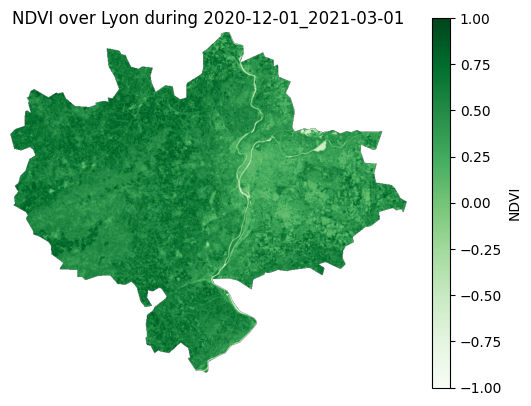

In [23]:
plt.figure()
plt.imshow(real_out_image[0], cmap='Greens', vmin=-1, vmax=1)
plt.colorbar(label="NDVI")
plt.title(f"NDVI over {cityname} during {timeperiod}")
plt.axis('off')
plt.show()
# -1 ndvi are mostly water